In [27]:
!pip install wordcloud

In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
stemmer = PorterStemmer()


In [18]:
# 2. Load Dataset
df = pd.read_csv('Tweets.csv')
df = df[['text', 'airline_sentiment']]  # Keep relevant columns
df = df[df['airline_sentiment'].isin(['positive', 'negative'])]  # Binary classification
df = df.dropna()

print(df.head())
print(df['airline_sentiment'].value_counts())


                                                text airline_sentiment
1  @VirginAmerica plus you've added commercials t...          positive
3  @VirginAmerica it's really aggressive to blast...          negative
4  @VirginAmerica and it's a really big bad thing...          negative
5  @VirginAmerica seriously would pay $30 a fligh...          negative
6  @VirginAmerica yes, nearly every time I fly VX...          positive
airline_sentiment
negative    9178
positive    2363
Name: count, dtype: int64


In [20]:
# 3. Text Preprocessing Function
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+|#\w+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    tokens = text.split()
    filtered = [stemmer.stem(w) for w in tokens if w not in stop_words]
    return " ".join(filtered)

df['clean_text'] = df['text'].apply(preprocess_text)
print(df[['text', 'clean_text']].head())


                                                text  \
1  @VirginAmerica plus you've added commercials t...   
3  @VirginAmerica it's really aggressive to blast...   
4  @VirginAmerica and it's a really big bad thing...   
5  @VirginAmerica seriously would pay $30 a fligh...   
6  @VirginAmerica yes, nearly every time I fly VX...   

                                          clean_text  
1                  plu youv ad commerci experi tacki  
3  realli aggress blast obnoxi entertain guest fa...  
4                               realli big bad thing  
5  serious would pay flight seat didnt play reall...  
6  ye nearli everi time fli vx ear worm wont go away  


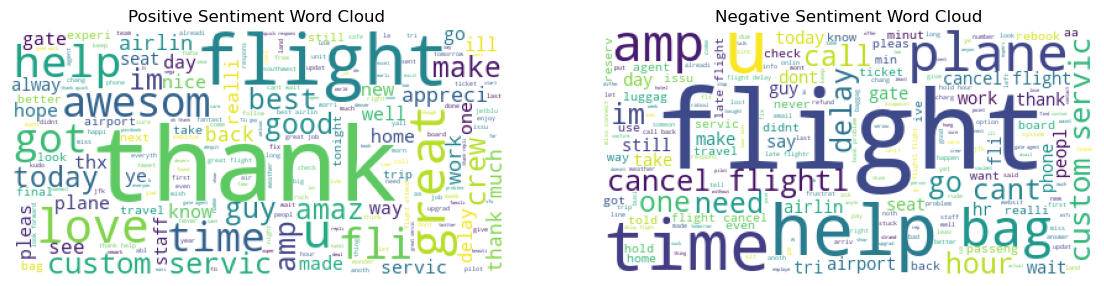

In [29]:
# 4. WordClouds
positive_text = ' '.join(df[df['airline_sentiment'] == 'positive']['clean_text'])
negative_text = ' '.join(df[df['airline_sentiment'] == 'negative']['clean_text'])

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(background_color='white').generate(positive_text))
plt.title('Positive Sentiment Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(background_color='white').generate(negative_text))
plt.title('Negative Sentiment Word Cloud')
plt.axis('off')
plt.show()


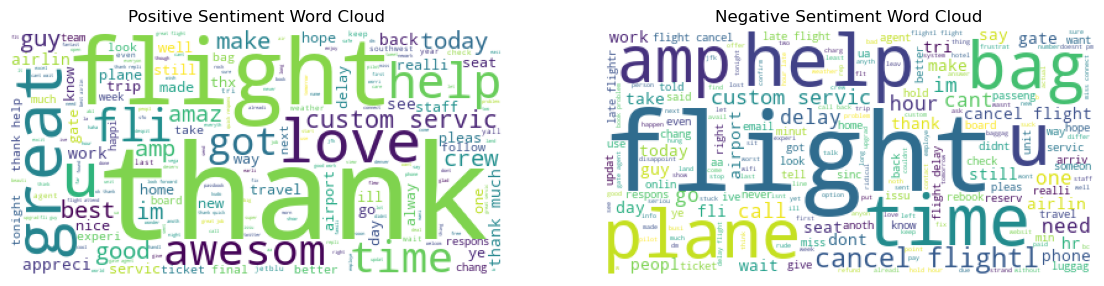

In [33]:
# 4. WordClouds
positive_text = ' '.join(df[df['airline_sentiment'] == 'positive']['clean_text'])
negative_text = ' '.join(df[df['airline_sentiment'] == 'negative']['clean_text'])

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(WordCloud(background_color='white').generate(positive_text))
plt.title('Positive Sentiment Word Cloud')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(WordCloud(background_color='white').generate(negative_text))
plt.title('Negative Sentiment Word Cloud')
plt.axis('off')
plt.show()


In [35]:
# 5. TF-IDF Vectorization
X = df['clean_text']
y = df['airline_sentiment']

vectorizer = TfidfVectorizer(max_features=5000)
X_vec = vectorizer.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_vec, y, test_size=0.2, random_state=42)


In [37]:
# 6. Train Logistic Regression Model
model = LogisticRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)


Accuracy: 0.9016890428757037

Classification Report:
               precision    recall  f1-score   support

    negative       0.90      0.98      0.94      1862
    positive       0.89      0.56      0.69       447

    accuracy                           0.90      2309
   macro avg       0.90      0.77      0.81      2309
weighted avg       0.90      0.90      0.89      2309



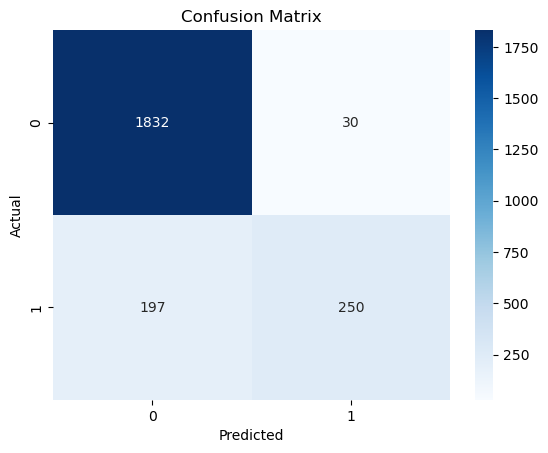

In [39]:
# 7. Evaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [41]:
# 8. Top Features by Sentiment
feature_names = vectorizer.get_feature_names_out()
coefs = model.coef_[0]
top_pos = np.argsort(coefs)[-10:]
top_neg = np.argsort(coefs)[:10]

print("🔵 Top Positive Words:")
print([feature_names[i] for i in top_pos])
print("\n🔴 Top Negative Words:")
print([feature_names[i] for i in top_neg])


🔵 Top Positive Words:
['good', 'kudo', 'appreci', 'thx', 'amaz', 'best', 'awesom', 'love', 'great', 'thank']

🔴 Top Negative Words:
['hour', 'delay', 'noth', 'worst', 'hold', 'cancel', 'bag', 'hr', 'call', 'luggag']


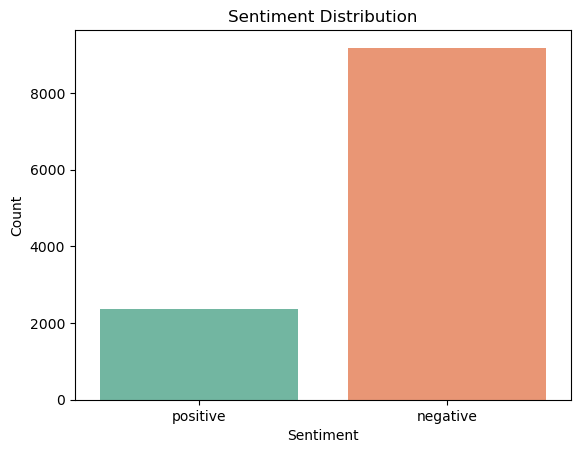

In [45]:
sns.countplot(data=df, x='airline_sentiment', hue='airline_sentiment', palette='Set2', legend=False)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


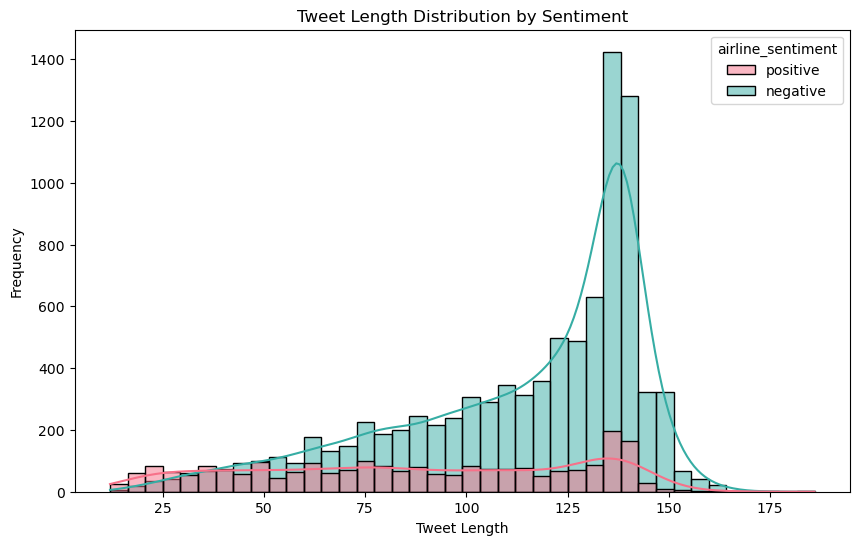

In [47]:
# Add a new column for tweet length
df['text_length'] = df['text'].apply(len)

# Plot
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='text_length', hue='airline_sentiment', kde=True, bins=40, palette='husl')
plt.title("Tweet Length Distribution by Sentiment")
plt.xlabel("Tweet Length")
plt.ylabel("Frequency")
plt.show()


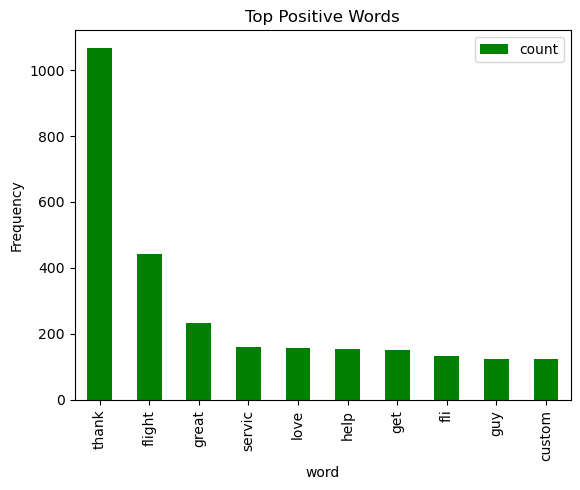

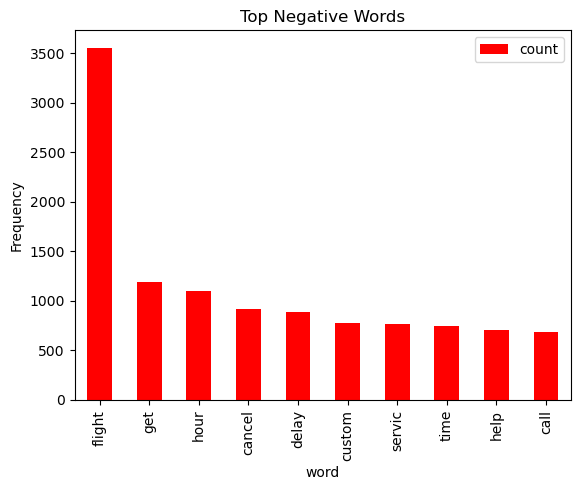

In [49]:
from collections import Counter

# Function to count words
def get_top_n_words(corpus, n=None):
    words = ' '.join(corpus).split()
    counter = Counter(words)
    return counter.most_common(n)

# Top words for positive
pos_words = get_top_n_words(df[df['airline_sentiment'] == 'positive']['clean_text'], 10)
neg_words = get_top_n_words(df[df['airline_sentiment'] == 'negative']['clean_text'], 10)

# Create DataFrame and plot
pd.DataFrame(pos_words, columns=['word', 'count']).set_index('word').plot(kind='bar', color='green', title='Top Positive Words')
plt.ylabel("Frequency")
plt.show()

pd.DataFrame(neg_words, columns=['word', 'count']).set_index('word').plot(kind='bar', color='red', title='Top Negative Words')
plt.ylabel("Frequency")
plt.show()


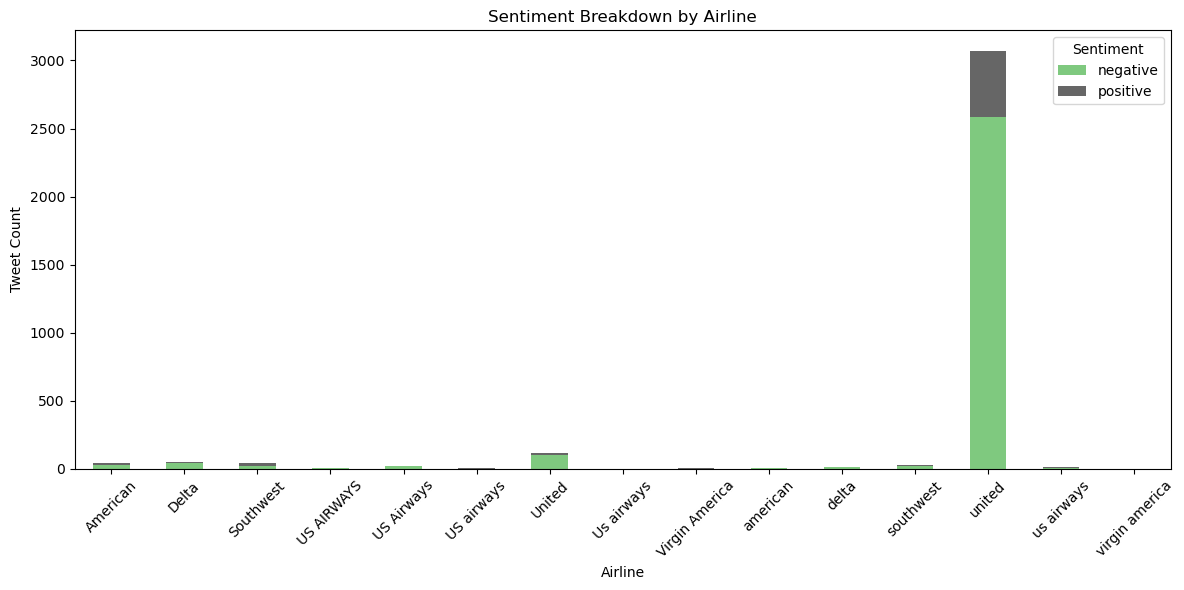

In [51]:
airline_sentiment_counts = df.groupby(['airline_sentiment', df['text'].str.extract(r'(?i)(?<=\b)(delta|united|southwest|american|us airways|virgin america)(?=\b)', expand=False)])\
                              .size().unstack().fillna(0)

airline_sentiment_counts.T.plot(kind='bar', stacked=True, figsize=(12,6), colormap='Accent')
plt.title("Sentiment Breakdown by Airline")
plt.xlabel("Airline")
plt.ylabel("Tweet Count")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()
